<a href="https://colab.research.google.com/github/AndreKaled/classificador-cao-gato/blob/main/classificador_cao_gato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descrição inicial
Este modelo é uma CNN binária treinada para distinguir cães de gatos. A rede aprende padrões visuais e produz um valor entre 0 e 1 representando o grau de "dogness" da imagem. Esse valor é então usado como predicado lógico dentro da arquitetura de Lógica Tensorial, permitindo combinar aprendizado de padrões com restrições lógicas sobre o comportamento desejado.


## Instalando dependências
Esse bloco usa %pip install para garantir que o ambiente tem tudo que o notebook vai usar: PyTorch, LTN (lógica neuralsimbólica), torchvision, kagglehub etc.
Esse bloco deve rodar apenas uma vez no Colab para preparar o terreno.

In [1]:
%pip install torch LTNtorch kagglehub pandas torchvision matplotlib

## Importando bibliotecas
Carrega tudo que o restante do notebook depende.
Torch para treino, torchvision para imagens...

In [2]:
import pandas as pd
import os
import warnings
import kagglehub
from kagglehub import KaggleDatasetAdapter
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import ltn
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

## Baixando dataset com imagens de cães e gatos
Puxa o dataset do Kaggle e extrai os arquivos.
Depois imprime o diretório para o usuário confirmar que o dataset realmente está presente.
Esse bloco também faz uma contagem dos arquivos.
O dataset utilizado é de [Cats-vs-Dogs, de Sachin](https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset)

In [3]:
# Baixa e extrai
dataset_name = "shaunthesheep/microsoft-catsvsdogs-dataset"
dataset_path = kagglehub.dataset_download(dataset_name)

print("Dataset baixado em:", dataset_path)

Using Colab cache for faster access to the 'microsoft-catsvsdogs-dataset' dataset.
Dataset baixado em: /kaggle/input/microsoft-catsvsdogs-dataset


### Explorando estrutura do dataset
Listagem das pastas, contagem de imagens por classe e visualização de algumas imagens.
Motivo: verificar se o dataset está limpo, balanceado e organizado antes de treinar qualquer coisa.

In [4]:
print(os.listdir(dataset_path))

['PetImages', 'readme[1].txt', 'MSR-LA - 3467.docx']


In [5]:
main_folder_path = Path(dataset_path)

all_folders = [d for d in main_folder_path.glob('**/') if d.is_dir()]

# Count number of files in each class
data = []
for folder in all_folders:
    folder_name = folder.name
    file_count = len(list(folder.glob('*.*')))
    if folder_name != dataset_path:
        data.append({'Folder Name': folder_name, 'File Count': file_count})

count = pd.DataFrame(data)

count = count.set_index('Folder Name')
count

,File Count
Folder Name,
microsoft-catsvsdogs-dataset,2
PetImages,0
Dog,12501
Cat,12501


In [6]:
print(f'Total {count.sum()}')

Total File Count    25004
dtype: int64


In [7]:
# mostra 5 imagens da classe
def plot_imgs(item_dir, top=10):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]

    plt.figure(figsize=(10, 10))

    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(os.path.basename(item_dir))

In [8]:
# entra na pasta certa, contendo as pastas com as imagens
print(os.listdir(os.path.join(dataset_path, 'PetImages')))
dataset_path = os.path.join(dataset_path, 'PetImages')

['Dog', 'Cat']


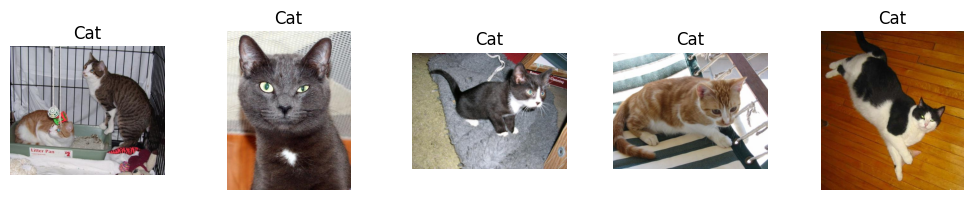

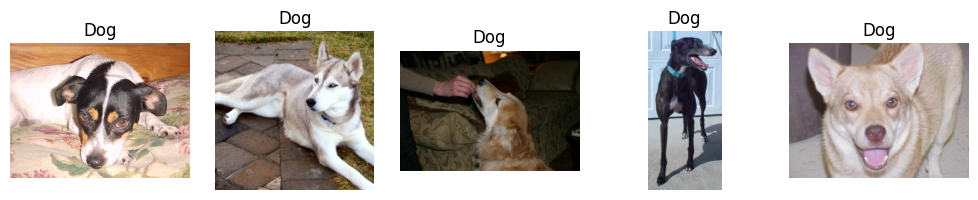

In [9]:
plot_imgs(dataset_path + '/Cat')
plot_imgs(dataset_path + '/Dog')

## Preparando DataLoader pra Pytorch
Transformações básicas: redimensionar para 224×224 e converter para tensor.
Depois:
* Filtra arquivos corrompidos.
* Separa os índices de cada classe (cat/dog).
* Faz splits de treino/validação.
* Cria os DataLoaders.

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # padroniza o tamanho de cada imagem
    transforms.ToTensor()
])

# Ignora arquivos inválidos por classe
def remover_corrompidos(path: str):
    ignore = {
        'Cat': [ '666.jpg' ],
        'Dog': [ '11702.jpg' ],
    }

    dir = os.path.basename(os.path.dirname(path))
    return os.path.basename(path) not in ignore[dir] and path.endswith('.jpg')

# dataset
dataset = datasets.ImageFolder(dataset_path, transform=transform, is_valid_file=remover_corrompidos)

# separar dataset em gatos e cães
indices = { c: [ ] for c in dataset.class_to_idx.keys() }
for i, label in enumerate(dataset.targets):
    path, label = dataset.imgs[i]
    indices[dataset.classes[label]].append(i)

dataset_cats = Subset(dataset, indices['Cat'])
dataset_dogs = Subset(dataset, indices['Dog'])

# dividindo em treino e validação
def dividir(dataset):
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    return random_split(dataset, [train_size, val_size])

train_cats, val_cats = dividir(dataset_cats)
train_dogs, val_dogs = dividir(dataset_dogs)

# dataloaders
train_cats_loader = DataLoader(train_cats, batch_size=64, shuffle=True, pin_memory=True)
train_dogs_loader = DataLoader(train_dogs, batch_size=64, shuffle=True, pin_memory=True)
val_cats_loader = DataLoader(val_cats, batch_size=64, shuffle=False, pin_memory=True)
val_dogs_loader = DataLoader(val_dogs, batch_size=64, shuffle=False, pin_memory=True)

print("Total de imagens:", len(dataset_cats) + len(dataset_dogs))
print("Treino:", len(train_cats), "gatos,", len(train_dogs), "cães | Validação:", len(val_cats), "gatos,", len(val_dogs), "cães")


Total de imagens: 24998
Treino: 11249 gatos, 11249 cães | Validação: 1250 gatos, 1250 cães


## Preparando CNN
Define a arquitetura da rede convolucional.
O caminho lógico:
* Três blocos conv+relu+pool → extraem padrões visuais.
* Flatten → joga para camadas densas.
* Dropout → reduz overfitting.
* Saída de 1 neurônio + sigmoid, já que é binário (dog = 1, cat = 0).


In [11]:
class CNNClassificador(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        # camadas convolucionais: detectam padrões na imagem (bordas, texturas, formas)
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # reduz resolução pela metade

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))

        # flatten + fully connected: transforma padrões em saidas classificaveis
        self.fc1 = nn.Linear(128*4*4, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.fc4 = nn.Sigmoid()

    def forward(self, x):
        # convolução + ReLU + Pooling
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = self.avgpool(x)

        # achata para passar pelas fully connected
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        # saida final: pontuação para cada classe
        x = self.fc3(x)
        x = self.fc4(x)
        return x

model = CNNClassificador(num_classes=2)
print(model)

CNNClassificador(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(4, 4))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (fc4): Sigmoid()
)


## Preparando treino da CNN
Aqui o device é escolhido (CUDA se disponível).
Define função de perda e otimizador.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ltn.device = device
model.to(device)

# função de perda padrão de classificacao binaria
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(device)

cuda


## Lógica LTN
Essa parte cria a camada de lógica fuzzy por cima do modelo neural.


* Carrega operadores lógicos (Not, And, Or, Implies).

* Define quantificadores com agregadores p-mean.

* Define o predicado D = ltn.Predicate(model), que conecta a rede neural com a lógica.
O valor do modelo passa a ser interpretado como "verdade" no intervalo [0,1].

Também carrega checkpoints (model.pt, índices do dataset), o notebook tenta continuar o treino anterior (se houver).

In [13]:
# Define os Agregadores e Otimizador
# Define logical operators
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
# SatAgg (Agregador de Satisfação) calculará a satisfação total da KB
sat_agg = ltn.fuzzy_ops.SatAgg()

Execute o trecho abaixo somente se já houver algum checkpoint preparado (no github há um modelo disponível)

In [19]:
import torch
import os

!rm -rf classificador-cao-gato

!git clone https://github.com/AndreKaled/classificador-cao-gato.git

!cp classificador-cao-gato/*.pt .

print("Arquivos baixados do repositório")
print("-------------------------------------------------------------------")


model = torch.load('model.pt', weights_only=False)

train_cats.indices = torch.load('train_cats_idx.pt')
train_dogs.indices = torch.load('train_dogs_idx.pt')
val_cats.indices = torch.load('val_cats_idx.pt')
val_dogs.indices = torch.load('val_dogs_idx.pt')

is_different = False
dataset_imgs = torch.load('dataset_idx.pt')

for (real, _), (saved, _) in zip(dataset.imgs, dataset_imgs):
    same_filename = os.path.basename(real) == os.path.basename(saved)
    same_class = os.path.basename(os.path.dirname(real)) == os.path.basename(os.path.dirname(saved))
    is_different = is_different or (not same_filename) or (not same_class)

if is_different:
    raise ValueError("Os índices de treino/teste estão incorretos, pois os arquivos foram lidos em uma ordem diferente.")
else:
    print("Sucesso! Modelo e índices carregados e validados corretamente.")

Cloning into 'classificador-cao-gato'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 81 (delta 10), reused 10 (delta 1), pack-reused 52 (from 2)
Receiving objects: 100% (81/81), 97.33 MiB | 40.27 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Arquivos baixados do repositório
-------------------------------------------------------------------
Sucesso! Modelo e índices carregados e validados corretamente.


usamos ```D = ltn.Predicate(model)``` porque o classificador foi implementado como um modelo binário que já retorna, via Sigmoid, um escalar por amostra no intervalo [0,1]. Esse escalar representa o grau de "cachorro" e encaixa diretamente na semântica fuzzy da LTN: verdade lógica contínua. Um predicado único simplifica a base de conhecimento (gatos são Not(D)) e reduz complexidade.

In [ ]:
D = ltn.Predicate(model)

Para cada batch:
* x_D recebe imagens de cães.
* x_C recebe imagens de gatos.

Depois:
* Aplica os axiomas: "Para todo cão, D(x) deve ser verdadeiro" e "Para todo gato, D(x) deve ser falso"

* O LTN calcula a satisfação lógica (Sat).
* A loss é 1 - Sat e entra no backprop.
* O otimizador ajusta a CNN respeitando os axiomas, não apenas dados.

No fim, imprime a média de satisfação e perda por época.

In [ ]:
# Loop de Treinamento
for epoch in range(40):
    train_loader = zip(train_cats_loader, train_dogs_loader)
    train_sat = train_loss = 0.
    for batch, (cats, dogs) in enumerate(train_loader):
        cat = cats[0].to(device)
        dog = dogs[0].to(device)

        optimizer.zero_grad()

        # 1. Defina as variáveis LTN com os dados de treinamento
        x_C = ltn.Variable("x_C", cat)
        x_D = ltn.Variable("x_D", dog)

        # 2. Calcule a satisfação total da Base de Conhecimento
        sat = sat_agg(
            # Axioma 1: Para todo x_D, D(x_D) deve ser verdadeiro
            Forall(x_D, D(x_D)),

            # Axioma 2: Para todo x_C, ~D(x_C) deve ser verdadeiro
            Forall(x_C, Not(D(x_C)))
        )

        # 3. Calcule a perda (loss)
        loss = 1. - sat

        # 4. Backpropagation e Otimização
        loss.backward()
        optimizer.step()

        train_sat += sat.item()
        train_loss += loss.item()

        if batch % 10 == 0:
            print(f" Batch {batch}: Nível de Satisfação (Sat): {sat.item():.4f}, Perda (Loss): {loss.item():.4f}")

    length = min(len(train_cats_loader), len(train_dogs_loader))
    train_sat /= length
    train_loss /= length
    print(f"Epoch {epoch}: Nível de Satisfação (Sat): {train_sat:.4f}, Perda (Loss): {train_loss:.4f}")

print("Treinamento concluído.")

 Batch 0: Nível de Satisfação (Sat): 0.4997, Perda (Loss): 0.5003
 Batch 10: Nível de Satisfação (Sat): 0.5014, Perda (Loss): 0.4986
 Batch 20: Nível de Satisfação (Sat): 0.5021, Perda (Loss): 0.4979
 Batch 30: Nível de Satisfação (Sat): 0.5034, Perda (Loss): 0.4966
 Batch 40: Nível de Satisfação (Sat): 0.5059, Perda (Loss): 0.4941
 Batch 50: Nível de Satisfação (Sat): 0.5143, Perda (Loss): 0.4857
 Batch 60: Nível de Satisfação (Sat): 0.5187, Perda (Loss): 0.4813
 Batch 70: Nível de Satisfação (Sat): 0.5177, Perda (Loss): 0.4823
 Batch 80: Nível de Satisfação (Sat): 0.5347, Perda (Loss): 0.4653
 Batch 90: Nível de Satisfação (Sat): 0.5141, Perda (Loss): 0.4859
 Batch 100: Nível de Satisfação (Sat): 0.5271, Perda (Loss): 0.4729
 Batch 110: Nível de Satisfação (Sat): 0.5384, Perda (Loss): 0.4616
 Batch 120: Nível de Satisfação (Sat): 0.5275, Perda (Loss): 0.4725
 Batch 130: Nível de Satisfação (Sat): 0.5140, Perda (Loss): 0.4860
 Batch 140: Nível de Satisfação (Sat): 0.5315, Perda (Loss)

Salva o modelo treinado e os índices das divisões de treino/validação, para continuar depois sem quebrar a correspondência entre o dataset local e o carregado.

In [ ]:
torch.save(model, 'model.pt')
torch.save(dataset.imgs, 'dataset_idx.pt')
torch.save(train_cats.indices, 'train_cats_idx.pt')
torch.save(train_dogs.indices, 'train_dogs_idx.pt')
torch.save(val_cats.indices, 'val_cats_idx.pt')
torch.save(val_dogs.indices, 'val_dogs_idx.pt')

Pega uma imagem de validação aleatória e roda D(x) para mostrar a “verdade lógica” do predicado.
Mostra a imagem e o score.
Serve como checagem visual se o modelo está minimamente coerente.

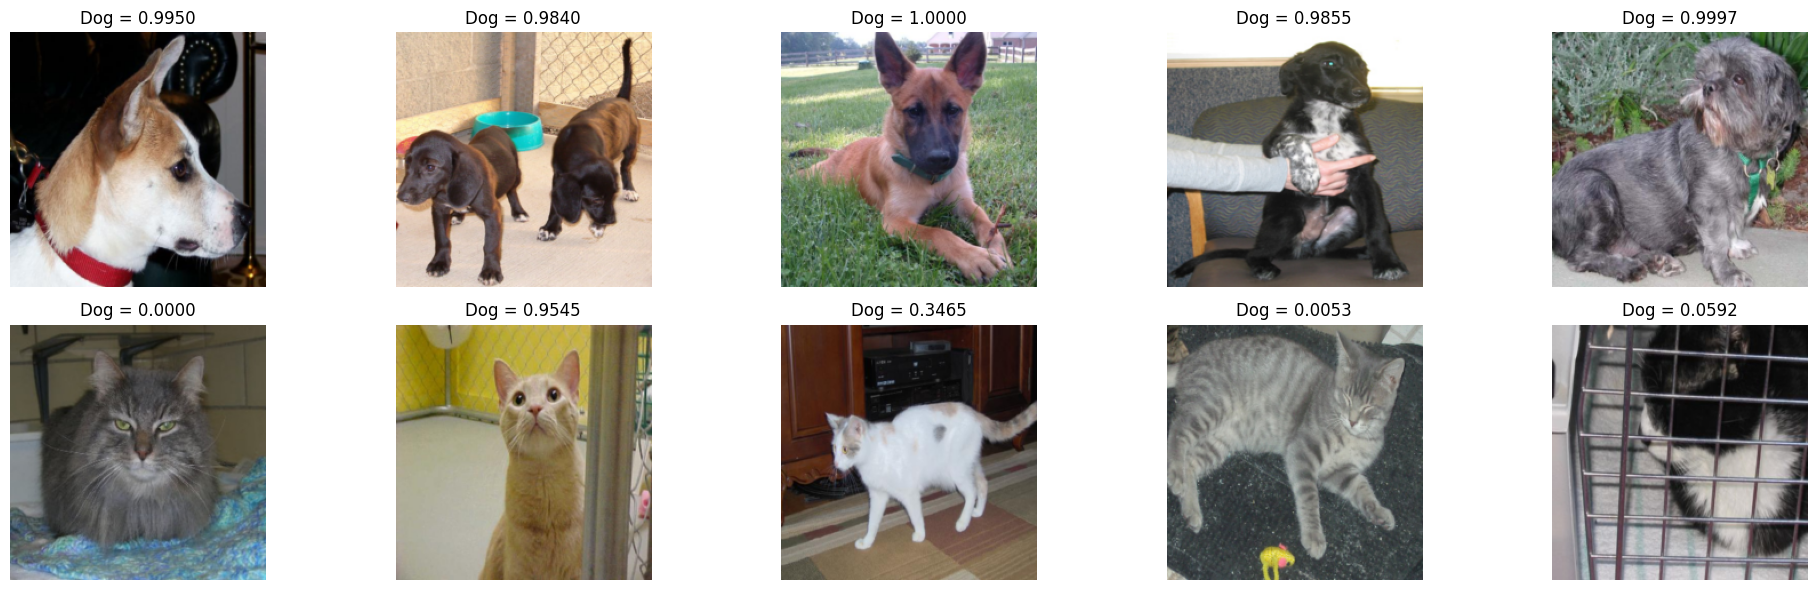

In [ ]:
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

model.eval()

# Quantidade de imagens por classe que você quer exibir
N = 5

if "val_dogs_iter" not in globals():
    val_dogs_iter = iter(val_dogs_loader)
if "val_cats_iter" not in globals():
    val_cats_iter = iter(val_cats_loader)

try:
    batch_dog = next(val_dogs_iter)
except StopIteration:
    val_dogs_iter = iter(val_dogs_loader)
    batch_dog = next(val_dogs_iter)

try:
    batch_cat = next(val_cats_iter)
except StopIteration:
    val_cats_iter = iter(val_cats_loader)
    batch_cat = next(val_cats_iter)

images_dog = batch_dog[0][:N]
images_cat = batch_cat[0][:N]

fig = plt.figure(figsize=(4*N, 6))

to_pil = ToPILImage()

for idx in range(N):
    # Dog
    dog = images_dog[idx:idx+1]
    dog_score = D(ltn.Variable("dog", dog)).value.item()
    # dog_score = model(dog.to(device)).item()   # sem LTN

    ax = fig.add_subplot(2, N, idx+1)
    ax.axis("off")
    ax.imshow(to_pil(dog[0].cpu()))
    ax.set_title(f"Dog = {dog_score:.4f}")

    # Cat
    cat = images_cat[idx:idx+1]
    cat_score = D(ltn.Variable("cat", cat)).value.item()
    # cat_score = model(cat.to(device)).item()

    ax = fig.add_subplot(2, N, N + idx + 1)
    ax.axis("off")
    ax.imshow(to_pil(cat[0].cpu()))
    ax.set_title(f"Dog = {cat_score:.4f}")

plt.tight_layout()
plt.show()


In [ ]:
if 'dogs' in globals(): del dogs
if 'cats' in globals(): del cats
if 'x_C' in globals(): del x_C
if 'x_D' in globals(): del x_D
if 'train_loader' in globals(): del train_loader
if 'axiom_D' in globals(): del axiom_D
if 'axiom_ND' in globals(): del axiom_ND
if 'loss' in globals(): del loss
if 'sat' in globals(): del sat

optimizer.zero_grad()
torch.cuda.empty_cache()

## Teste manual
Se desejar, pode incluir uma imagem própria no notebook e testar o modelo com sua imagem.
Lembre-se de alterar o valor de ```img_path```.

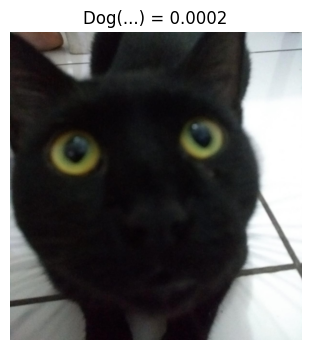

modelo acha que é gato


In [ ]:
from PIL import Image
from torchvision import transforms
import torch
from torchvision.transforms import ToPILImage

model.eval()

# Caminho da imagem no diretório raiz do notebook
img_path = "gato1.jpeg"

# Carrega e prepara a imagem
img_pil = Image.open(img_path).convert("RGB")
img_tensor = transform(img_pil).unsqueeze(0)

score = D(ltn.Variable("img", img_tensor)).value.item()

plt.figure(figsize=(4,4))
plt.axis("off")
plt.imshow(img_pil)
plt.title(f"Dog(...) = {score:.4f}")
plt.show()

if score >= 0.5:
    print("modelo acha que é cachorro")
else:
    print("modelo acha que é gato")


# Avaliação final (acurácia)

Percorre a validação inteira, computando:

* quantos dogs têm score ≥ 0.5
* quantos cats têm score < 0.5

Somando tudo, calcula a acurácia.

In [ ]:
model.eval()

with torch.no_grad():
  val_loader = zip(val_cats_loader, val_dogs_loader)

  val_sat = val_loss = 0.
  correct = total = 0.
  for batch, (cats, dogs) in enumerate(val_loader):
    cat = cats[0][:]
    dog = dogs[0][:]

    # 1. Defina as variáveis LTN com os dados de treinamento
    x_C = ltn.Variable("x_C", cat)
    x_D = ltn.Variable("x_D", dog)

    pred_cats = D(x_C)
    pred_dogs = D(x_D)

    correct_dogs = (pred_dogs.value >= 0.5).sum()
    total_dogs = len(pred_dogs.value)
    correct_cats = (pred_cats.value < 0.5).sum()
    total_cats = len(pred_cats.value)

    correct += correct_dogs + correct_cats
    total += total_dogs + total_cats
    print(correct_dogs, total_dogs, " / ", correct_cats, total_cats)
  print(f"Acurácia: {correct/total:.4f}")

tensor(61, device='cuda:0') 64  /  tensor(57, device='cuda:0') 64
tensor(60, device='cuda:0') 64  /  tensor(58, device='cuda:0') 64
tensor(58, device='cuda:0') 64  /  tensor(60, device='cuda:0') 64
tensor(61, device='cuda:0') 64  /  tensor(58, device='cuda:0') 64
tensor(55, device='cuda:0') 64  /  tensor(56, device='cuda:0') 64
tensor(60, device='cuda:0') 64  /  tensor(54, device='cuda:0') 64
tensor(61, device='cuda:0') 64  /  tensor(56, device='cuda:0') 64
tensor(58, device='cuda:0') 64  /  tensor(55, device='cuda:0') 64
tensor(59, device='cuda:0') 64  /  tensor(59, device='cuda:0') 64
tensor(58, device='cuda:0') 64  /  tensor(50, device='cuda:0') 64
tensor(57, device='cuda:0') 64  /  tensor(55, device='cuda:0') 64
tensor(60, device='cuda:0') 64  /  tensor(58, device='cuda:0') 64
tensor(57, device='cuda:0') 64  /  tensor(56, device='cuda:0') 64
tensor(57, device='cuda:0') 64  /  tensor(59, device='cuda:0') 64
tensor(58, device='cuda:0') 64  /  tensor(57, device='cuda:0') 64
tensor(59,